## Imports 

___

In [56]:
import pywt
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import os
import math

___
## Settings
___

In [57]:
num_levels  = 1
filter      = 'db2'

# pre defined supported filters "haar", "db2", "db3", "db4" or pass in arrays yourself

___
## File Management
___

In [58]:
def load_dicom_folder(folder_path):
    """
    Reads a folder of .dcm files and stores the pixel data in a 3D NumPy array.
    Parameters:
        folder_path: str: The path to the folder containing the .dcm files.
    Returns:
        numpy.ndarray: A 3D array containing the pixel data from the DICOM files.
    """
    slices = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.dcm'):
            file_path = os.path.join(folder_path, filename)
            ds = pydicom.dcmread(file_path)
            slices.append(ds.pixel_array)
    volume = np.stack(slices, axis=0)

    return volume

In [59]:
def write_arr(array_3d, filename):
    """
    Write a 3D integer array to a binary file, including its dimensions.
    Parameters:
        array_3d (np.ndarray): The 3D array to write.
        filename (str): The name of the file to write to.
    """
    with open(filename, 'wb') as f:
        f.write(np.array(array_3d.shape, dtype=np.int32).tobytes())
        f.write(array_3d.astype(np.int32).tobytes())

In [60]:
def read_arr(filename):
    """
    Read a 3D integer array from a binary file, including its dimensions.
    Parameters:
        filename (str): The name of the file to read from.
    Returns:
        tuple: A tuple containing the shape of the array and the array itself.
    """
    with open(filename, 'rb') as f:
        shape = np.fromfile(f, dtype=np.int32, count=3)
        array_data = np.fromfile(f, dtype=np.int32).reshape(shape)
    
    return array_data

___
## Display of 3D Images
This function displays a list of 3d images by spliting each image into layers and displaying them individually
___

In [61]:
def map_slices_to_square(volume):
    """
    Arranges the 3D volume of DICOM slices into a single 2D image by tiling them
    in a roughly square grid.
    
    Parameters:
        volume (numpy.ndarray): A 3D array where each slice is a 2D image.
        
    Returns:
        numpy.ndarray: A 2D array containing the tiled image.
    """
    # Get number of slices and the shape of each slice
    num_slices, height, width = volume.shape
    
    # Calculate the grid size needed for a square layout
    grid_size = math.ceil(math.sqrt(num_slices))
    
    # Initialize a large empty canvas for the tiled image
    tiled_image = np.zeros((grid_size * height, grid_size * width), dtype=volume.dtype)
    
    # Place each slice in the grid
    for i in range(num_slices):
        row = i // grid_size
        col = i % grid_size
        tiled_image[row * height: (row + 1) * height, col * width: (col + 1) * width] = volume[i]
    
    return tiled_image

def map_and_plot_volumes(volumes, sub_bands, level):
    """
    Maps each 3D volume in a list of volumes to a tiled 2D image, 
    and plots them separately with titles for each sub-band.
    
    Parameters:
        volumes (list of numpy.ndarray): List of 3D volumes, each being a stack of 2D slices.
        sub_bands (list of str): List of sub-band names corresponding to the volumes.
        
    Returns:
        None
    """
    plt.figure(figsize=(20, 5))
    for i, volume in enumerate(volumes):
        tiled_image = map_slices_to_square(volume) 
        
        plt.subplot(1, 8, i + 1)
        plt.imshow(tiled_image, cmap='gray')
        if(level == -1):
            plt.title(f'{sub_bands[i]}')
        else:
            plt.title(f'Level {level + 1} - {sub_bands[i]}')
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

In [62]:
def plot_wavelet_coeffs(levels):
    """
    Plot each level of 3D DWT sub-bands in separate figures.
    
    Parameters:
        levels (list): List of dictionaries containing 3D DWT sub-bands for each level.
    """
    num_levels = len(levels)
    
    for level_idx, coeffs in enumerate(levels):
        plt.figure(figsize=(20, 5))  # New figure for each level
        for i, (band, volume) in enumerate(coeffs.items()):
            tiled_image = map_slices_to_square(volume)  # Tile each sub-band volume
            plt.subplot(1, 8, i + 1)  # 1 row, 8 columns
            plt.imshow(tiled_image, cmap='gray')
            plt.title(f'Level {level_idx + 1} - {band}')
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

In [63]:
import os
import numpy as np

def read_dwt_results(folder_path, num_levels, filename):
    """
    Reads discrete wavelet transform results from a single file, 
    maps them to 2D images, and plots them.
    
    Parameters:
        folder_path (str): The path to the folder containing the binary file.
        num_levels (int): The number of wavelet levels to process.
        filename (str): The name of the binary file containing the data.
        
    Returns:
        list: A list of level data read from the file.
    """
    sub_bands = ['LLL', 'LLH', 'LHL', 'LHH', 'HLL', 'HLH', 'HHL', 'HHH']
    all_levels = []

    file_path = os.path.join(folder_path, filename)
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return all_levels

    # Read the entire file into a numpy array
    data = np.fromfile(file_path, dtype=np.float32)

    # Assuming the shape of the data is known or can be inferred
    depth, rows, cols = 78, 512, 512  # Example dimensions, adjust as needed
    expected_size = depth * rows * cols

    if data.size < expected_size:
        raise ValueError(f"Data size {data.size} is smaller than expected size {expected_size} for shape ({depth}, {rows}, {cols})")
    elif data.size > expected_size:
        print(f"Warning: Data size {data.size} is larger than expected size {expected_size}. Trimming the data.")
        data = data[:expected_size]

    data = data.reshape((depth, rows, cols))

    for level in range(num_levels):
        level_files = {}
        level_arr = []

        # Define the dimensions of each sub-band
        sub_depth = depth // 2
        sub_rows = rows // 2
        sub_cols = cols // 2

        # Extract sub-bands
        level_files['LLL'] = data[:sub_depth, :sub_rows, :sub_cols]
        level_files['LLH'] = data[:sub_depth, :sub_rows, sub_cols:]
        level_files['LHL'] = data[:sub_depth, sub_rows:, :sub_cols]
        level_files['LHH'] = data[:sub_depth, sub_rows:, sub_cols:]
        level_files['HLL'] = data[sub_depth:, :sub_rows, :sub_cols]
        level_files['HLH'] = data[sub_depth:, :sub_rows, sub_cols:]
        level_files['HHL'] = data[sub_depth:, sub_rows:, :sub_cols]
        level_files['HHH'] = data[sub_depth:, sub_rows:, sub_cols:]

        for sub_band in sub_bands:
            level_arr.append(level_files[sub_band])

        all_levels.append(level_files)

        # Directly map and plot the volumes for this level, passing sub_bands
        map_and_plot_volumes(level_arr, sub_bands, level)

    return all_levels

___
## PY Wavelt 3D DWT

function is used to perform a 3D DWT using Pywavelets
___

In [64]:
def perform_multi_level_3d_dwt(volume, wavelet, num_levels):
    """
    Perform a multi-level 3D Discrete Wavelet Transform on a 3D volume.
    
    Parameters:
        volume (numpy.ndarray): A 3D array representing the DICOM volume.
        num_levels (int): The number of levels of DWT to perform.
        
    Returns:
        list: A list of dictionaries, where each dictionary contains keys 'LLL', 'LLH', 
              'LHL', 'LHH', 'HLL', 'HLH', 'HHL', 'HHH' representing the different 
              sub-bands of each level of the 3D DWT.
    """
    levels = []
    
    # Initialize the current volume to the original volume
    current_volume = volume
    
    for level in range(num_levels):
        # Perform a single-level 3D wavelet decomposition
        coeffs = pywt.dwtn(current_volume, wavelet, axes=(0, 1, 2))
        
        # Renaming the coefficients to conventional sub-band names
        renamed_coeffs = {
            'LLL': coeffs['aaa'],        'LLH': coeffs['aad'],
            'LHL': coeffs['ada'],        'LHH': coeffs['add'],
            'HLL': coeffs['daa'],        'HLH': coeffs['dad'],
            'HHL': coeffs['dda'],        'HHH': coeffs['ddd']
        }
        
        # Store the coefficients for this level
        levels.append(renamed_coeffs)
        
        # Update the current volume to the low-pass sub-band for the next level
        current_volume = renamed_coeffs['LLL']
    
    return levels

___
## Dicom Folder
___

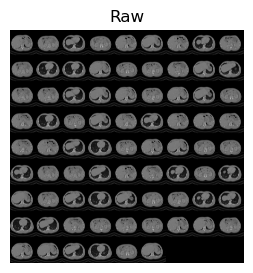

In [65]:
dicom_3d_array = load_dicom_folder("../DICOM->BIN/Test_Sets/CT/3/DICOM_anon")
map_and_plot_volumes([dicom_3d_array], ["Raw"], -1)

### Py Wavelets 3D DWT

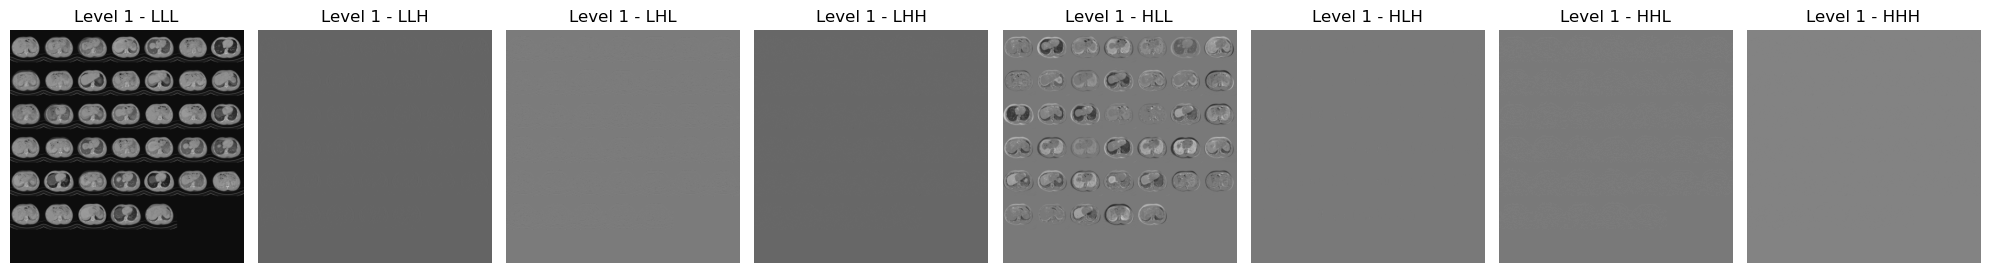

In [66]:
coeffs = perform_multi_level_3d_dwt(dicom_3d_array, filter, num_levels)
plot_wavelet_coeffs(coeffs)

### Writing array into a readable .bin format for C++

In [67]:
# write_arr(dicom_3d_array, './Data/dicom_arr.bin')
# print(dicom_3d_array.shape)

### Running C++ Code

In [68]:
# executable_path = "./build/DWT_3D"
# input_file = "./Data/dicom_arr.bin"

# try:
#     result = subprocess.run(
#         [executable_path, input_file, str(num_levels), filter],
#         check=True,
#         text=True,
#         capture_output=True
#     )
    
#     print("Program Output:")
#     print(result.stdout)
# except subprocess.CalledProcessError as e:
#     print("An error occurred while running the program:")
#     print(e.stderr)

### Reading C++ result

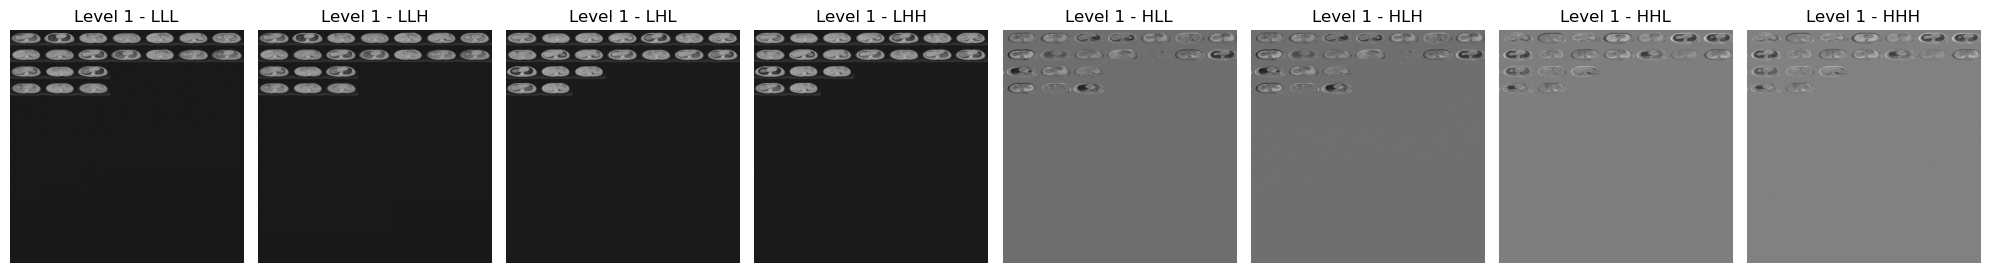

In [69]:
folder_path = '../../Final/serial/outputs'
result_cpp = read_dwt_results(folder_path, 1, '3out.bin')

___
## Comparison of results
Here we will compare the result of the output by 1 level at slice 0

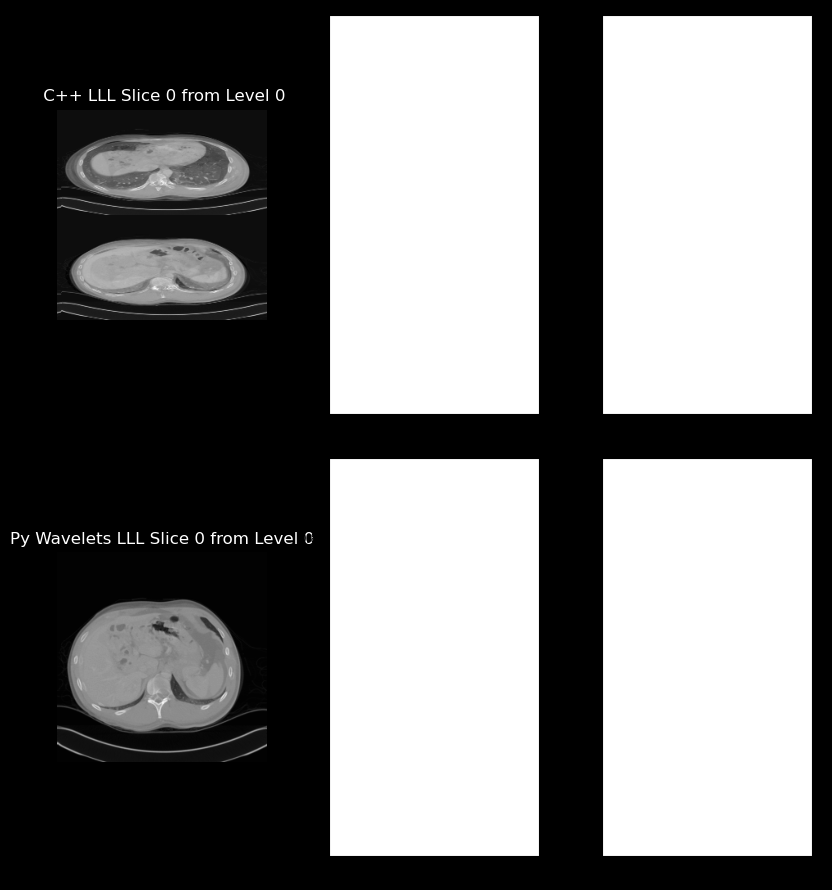

In [70]:
slice_index = 0
fig, axes = plt.subplots(2, max(num_levels, 3), figsize=(4 * (num_levels + 1), 9), facecolor='black')

# Plot C++ LLL slices
for level in range(num_levels):
    axes[0, level].imshow(result_cpp[level]['LLL'][slice_index], cmap='gray')
    axes[0, level].axis('off')
    axes[0, level].set_title(f' C++ LLL Slice {slice_index} from Level {level}', color='white')

# Plot Py Wavelets LLL slices
for level in range(num_levels):
    axes[1, level].imshow(coeffs[level]['LLL'][slice_index], cmap='gray')
    axes[1, level].axis('off')
    axes[1, level].set_title(f'Py Wavelets LLL Slice {slice_index} from Level {level}', color='white')

plt.tight_layout()
plt.show()